<a href="https://www.kaggle.com/code/patimejia/contrails-init-data-stats-histograms?scriptVersionId=137668899" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

base_directory = '/kaggle/input/opencontrails-mini-sample/'

printmd(f"### **Base Directory:** {base_directory}")

### **Base Directory:** /kaggle/input/opencontrails-mini-sample/

In [2]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

printmd("### Input Directory")

from utils_directory_tree_generator import get_directory_tree

tree_generator = get_directory_tree(
    start_path=base_directory,  # Updated this line
    max_depth=5,
    include_files=True,
    sort_by='type',
    reverse=False,
    max_items=4
)
for line in tree_generator:
    print(line)

### Input Directory

input
    opencontrails-mini-sample
        opencontrails_mini_sample
            validation
                1002653297254493116
                1000834164244036115
                1012978360687713914
                1010397530434035516
            test
                1002653297254493116
                1000834164244036115
            train
                1000603527582775543
                100071707854144929
                1000823728928031783
                1000660467359258186
            validation_metadata.json
    google-research-identify-contrails-reduce-global-warming
        validation
            3687499407028137410
                band_10.npy
                band_14.npy
                band_15.npy
                band_16.npy
            6558861185867890815
                band_10.npy
                band_14.npy
                band_15.npy
                band_16.npy
            7355354609194882312
                band_10.npy
                band_14.npy
                band

In [3]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

printmd("### Generating Stats Report and Overlaid Band Histogram ...")

import os
import time
import collections
import math
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle


class DataAnalyzer:
    @staticmethod
    def calculate_statistics(data):
        if data.size == 0:
            return {
                'shape': data.shape,
                'size': data.size,
                'mean': None,
                'std_dev': None,
                'min': None,
                'max': None,
                'median': None,
                'percentiles': [None, None, None],
                'all_zeros': True,
                'zero_count': 0,
                'non_zero_count': 0,
                'has_nan': False,
                'has_inf': False,
                'histogram': ([], [])
            }
        
        hist, bins = np.histogram(data, bins=50)
        hist = hist / data.size
        return {
            'shape': data.shape,
            'size': data.size,
            'mean': np.mean(data),
            'std_dev': np.std(data),
            'min': np.min(data),
            'max': np.max(data),
            'median': np.median(data),
            'percentiles': np.percentile(data, [25, 50, 75]),
            'all_zeros': np.all(data == 0),
            'zero_count': np.count_nonzero(data == 0),
            'non_zero_count': np.count_nonzero(data),
            'has_nan': np.isnan(data).any(),
            'has_inf': np.isinf(data).any(),
            'histogram': (hist, bins)
        }


class HistogramGenerator:
    @staticmethod
    def group_and_plot_histograms_by_dataset_record(file_stats, output_dir, histograms_per_row):
        results_by_dataset_record = collections.defaultdict(list)
        
        for filepath, stats in file_stats.items():
            _, dataset, record_id, _ = filepath.split('/')[-4:]
            results_by_dataset_record[(dataset, record_id)].append((filepath, stats))

        dataset_records = sorted(results_by_dataset_record.keys())
        num_histograms = len(dataset_records)
        num_rows = math.ceil(num_histograms / histograms_per_row)
        fig_band = plt.figure(figsize=(15, num_rows * 7))

        patches_band = []
        labels_band = []

        for i, (dataset, record_id) in enumerate(dataset_records):
            record_results = results_by_dataset_record[(dataset, record_id)]
            band_results = [result for result in record_results if 'band_' in result[0].split('/')[-1]]
            colors_band = cm.viridis(np.linspace(0, 1, len(band_results)))

            ax_band = fig_band.add_subplot(num_rows, histograms_per_row, i + 1)
            for color, (filepath, stats) in zip(colors_band, band_results):
                hist, bins = stats['histogram']
                ax_band.bar(bins[:-1], hist, width=np.diff(bins), ec="k", align="edge", alpha=0.5, color=color)

                if os.path.basename(filepath) not in labels_band:
                    labels_band.append(os.path.basename(filepath))
                    patches_band.append(Rectangle((0, 0), 1, 1, fc=color))

            ax_band.set_title(f'Bands for record {record_id} in {dataset}')
            ax_band.grid(True)

        fig_band.legend(patches_band, labels_band, loc='upper right')
        output_filepath_band = os.path.join(output_dir, f'tiled_bands_histogram.png')
        fig_band.savefig(output_filepath_band)
        plt.close(fig_band)
        
    @staticmethod
    def display_saved_image(img_path):
        # Load and display saved image
        img = mpimg.imread(img_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img, aspect='auto')
        plt.axis('off')
        plt.show()


class ReportGenerator:
    ANCHOR_REGEX = re.compile(r'[^\w\- ]', re.UNICODE)

    @staticmethod
    def normalize_anchor(text):
        text = text.lower().replace(' ', '-')
        return ReportGenerator.ANCHOR_REGEX.sub('', text)

    @staticmethod
    def generate_markdown_for_file(filepath, stats):
        markdown = f"### {filepath}\n\n"
        for stat, value in stats.items():
            markdown += f"- **{stat.capitalize()}**: {value}\n"
        markdown += f'\n[Back to ToC](#{ReportGenerator.normalize_anchor("table of contents")})\n\n'
        return markdown

    @staticmethod
    def save_results(markdown_results, files_with_zeros, files_without_zeros):
        total_files = len(markdown_results)
        summary = f"## Summary\n\n- Total files processed: {total_files}\n"
        summary += f"- Files with zeros: {len(files_with_zeros)}\n"
        summary += f"- Files without zeros: {len(files_without_zeros)}\n\n"
        
        markdown = '## Table of Contents\n\n- [Summary](#summary)\n'
        markdown += summary + '\n'.join(markdown_results)
        
        with open('/kaggle/working/numpy_stats/zeros_dataset_report.md', 'w') as results_file:
            results_file.write(markdown)


class FileProcessor:
    @staticmethod
    def process_file(filepath):
        try:
            data = np.load(filepath)
            stats = DataAnalyzer.calculate_statistics(data)
            markdown = ReportGenerator.generate_markdown_for_file(filepath, stats)
            has_zeros = stats['zero_count'] > 0
            return filepath, markdown, has_zeros, stats
        except Exception as e:
            print(f"Error processing file {filepath}: {str(e)}")
            return None, None, None, None

    @staticmethod
    def process_directory(directory_path):
        markdown_results, file_stats = [], {}
        files_with_zeros, files_without_zeros = [], []

        for root, dirs, files in os.walk(directory_path):
            dirs[:] = [d for d in dirs if d not in ['test']] #adjust to include test dir
            for file in filter(lambda f: f.endswith('.npy'), files):
                filepath, markdown, has_zeros, stats = FileProcessor.process_file(os.path.join(root, file))
                if all([filepath, markdown, stats]):
                    markdown_results.append(markdown)
                    file_stats[filepath] = stats
                    (files_with_zeros if has_zeros else files_without_zeros).append(filepath)

        return markdown_results, files_with_zeros, files_without_zeros, file_stats


def main():
    start_time = time.time()

    os.makedirs('/kaggle/working/numpy_stats', exist_ok=True)
    try:
        markdown_results, files_with_zeros, files_without_zeros, file_stats = FileProcessor.process_directory(base_directory)
        ReportGenerator.save_results(markdown_results, files_with_zeros, files_without_zeros)
        HistogramGenerator.group_and_plot_histograms_by_dataset_record(file_stats, '/kaggle/working/numpy_stats', 3) # Adjust number of histograms per row here
    except Exception as e:
        print(f"An error occurred: {str(e)}")

    elapsed_time = time.time() - start_time
    processed_files_count = len(markdown_results)
    print(f"Total time taken: {elapsed_time:.4f} seconds")
    print(f"Total number of files processed: {processed_files_count}")
    print(f"Processed {processed_files_count/elapsed_time:.2f} files per second.")


main()


### Generating Stats Report and Overlaid Band Histogram ...

Total time taken: 12.0235 seconds
Total number of files processed: 105
Processed 8.73 files per second.


# Usage:
- Set `base_directory`:
  - Entire dataset: `'/kaggle/input/google-research-identify-contrails-reduce-global-warming'`
  - `test` folder only: `'/kaggle/input/google-research-identify-contrails-reduce-global-warming/test'`
- Execute code.
- Check output at `'/kaggle/working/numpy_stats'`.

In [4]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

printmd("### Output Directory:")

# ---

from utils_directory_tree_generator import get_directory_tree

tree_generator = get_directory_tree(
    start_path='/kaggle/working/numpy_stats',
    max_depth=4,
    include_files=True,
    sort_by='type',
    reverse=False,
    max_items=4
)
for line in tree_generator:
    print(line)

### Output Directory:

numpy_stats
    tiled_bands_histogram.png
    zeros_dataset_report.md


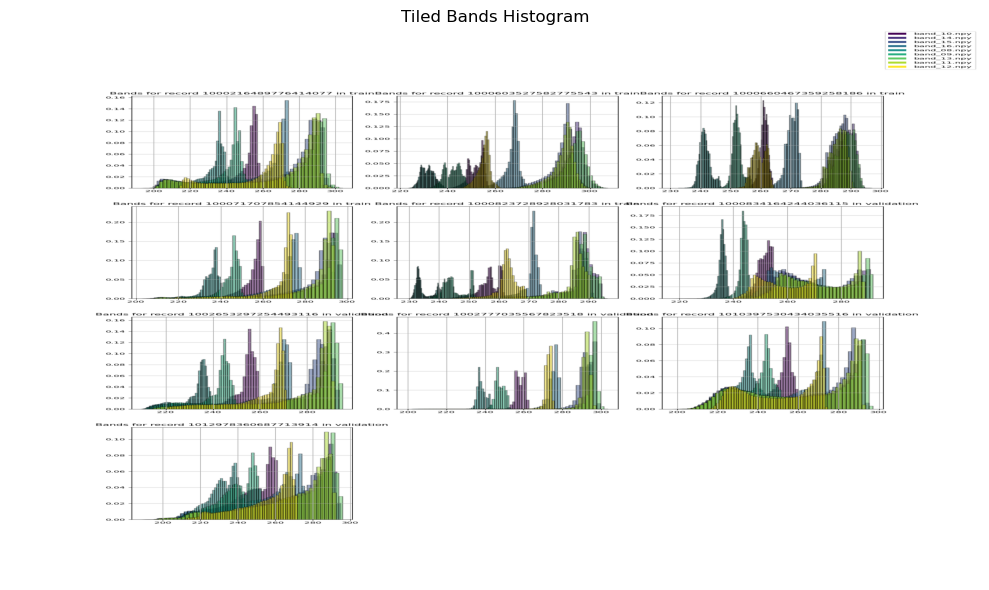

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def get_image_title(img_path):
    # Get title from path
    return img_path.split('/')[-1].split('.')[0].replace('_', ' ').title()

def display_image(ax, img_path):
    # Load and display image
    img = mpimg.imread(img_path)
    ax.imshow(img, aspect='auto')
    ax.axis('off')
    ax.set_title(get_image_title(img_path))

def display_images(image_files):
    # Display list of images
    n_images = len(image_files)
    fig = plt.figure(figsize=(10 * n_images, 6))
    
    for i, image_file in enumerate(image_files):
        ax = fig.add_subplot(1, n_images, i+1)
        img_path = f'/kaggle/working/numpy_stats/{image_file}'
        display_image(ax, img_path)
    
    plt.tight_layout()
    plt.show()

# Image list
image_files = ['tiled_bands_histogram.png']
display_images(image_files)

In [6]:
# from IPython.display import Markdown

# # Display contents of zeros_dataset_report.md
# with open('/kaggle/working/numpy_stats/zeros_dataset_report.md', 'r') as f:
#     markdown_content = f.read()
# Markdown(markdown_content)


<div style="background-color: #f2f2f2; padding: 53px; border-radius: 5px;">
  <h3>If you found this notebook helpful...</h3>
  <p>
  Please consider giving it a star. Your support helps me continue to develop high-quality code and pursue my career as a data analyst/engineer. Feedback is always welcome and appreciated. Thank you for taking the time to read my work! 
  </p> 
  <h4>
  <p style="text-align: right;">
  <a href="https://github.com/patmejia"> - pat [¬º-°]¬ </a>
  </h4>
  </p>
</div>